## Машинное обучение 
### Факультет математики НИУ ВШЭ, 2020-21 учебный год

_Илья Щуров, Соня Дымченко, Руслан Хайдуров, Павел Егоров, Максим Бекетов_

[Страница курса](http://wiki.cs.hse.ru/Машинное_обучение_на_матфаке_2020)


## Домашнее задание 3. Метод k ближайших соседей

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from scipy.special import softmax
from scipy import spatial
from scipy.stats import mode
%matplotlib inline

## О библиотеках
В задачах 1 и 2 вам предстоит написать функции, аналоги которых есть в библиотеке *scikit-learn* (`sklearn`). Реализовывать различные методы машинного обучения «с нуля» очень полезно: способность реализовать какой-то метод самому — это главный критерий того, что вы понимаете, как он работает. В то же время, разбираться в существующих библиотеках тоже полезно — именно с ними вам придётся столкнуться в любой практической работе. Поэтому мы рекомендуем решить эти задачи двумя способами: вручную и с помощью `sklearn`. За оба положены баллы (хотя за `sklearn` поменьше, потому что это проще).

## Задание 1 (4+1 баллов)

Вам предстоит реализовать две версии метода $k$ ближайших соседей (kNN) — обычный (который обсуждался на семинаре) и со взвешиванием.

В качестве метрики мы будем использовать $d_p(\cdot,\ \cdot)$ — [расстояние Минковского](https://en.wikipedia.org/wiki/Minkowski_distance) порядка $p$.



Пусть нам нужно вычислить значение $y$ для некоторого $x_{new}$, наши данные заданы как $\{x_i, y_i\}_{i=1}^l$. Обычный метод $k$ ближайших соседей находит такие $i_1, \ldots, i_k$, что $\{x_{i_m}\}_{m=1}^k$ являются $k$ ближайшими соседями для точки $x_{new}$ (по выбранной метрике $d_p(\cdot,\ \cdot)$), и полагает, что значение нового объекта:

$$\widehat{y} = \underset{c \in C}{\mathrm{argmax}}\ \sum_{m=1}^k[y_{i_m} = c],$$
где $C$ — множество классов, а $[y_{i_m}=c]$ — выражение, равное 1, если $y_{i_m}=c$, и 0 в противном случае. То есть $\widehat y$ — мода классов $k$ ближайших соседей. Модифицированный метод $k$ ближайших соседей, который вам предстоит реализовать, использует другую оценку:

$$\widehat y = \underset{c \in C}{\mathrm{argmax}} \sum_{i=1}^l w_{i}[y_i=c],$$
где вес $w_i$ вычисляется следующим образом:
$$
    w_i = \cfrac{\exp(-d_p(x_{new}, x_i))}{\sum_{j=1}^l \exp(-d_p(x_{new}, x_j))}
$$


Таким образом, модифицированный метод присваивает $i$-му объекту вес $w_{i}$, уменьшающийся с увеличением расстояния до $x_{new}$, вместо того чтобы присваивать $k$ ближайшим соседям вес $1$, а остальным $0$.

---

Ниже предоставлен шаблон функции для реализации метода, который возвращает предсказания для тестовой выборки, используя взвешенный или обычный kNN (с возможностью выбора порядка $p$ метрики расстояния). Код для обычного kNN можно взять из семинара; если вы не были на семинаре — придётся написать самостоятельно.

---

За решение задачи вручную (только с использованием `numpy` и `scipy`) можно получить **до четырёх баллов**. Полный балл за эту часть ставится в том случае, если решение не использует циклы. За решение с циклами можно получить не больше **двух баллов** из четырёх.

За решение задачи с помощью `sklearn` можно получить **один балл**.

**Подсказка.** Вам придётся вычислить расстояние Минковского между $x_{new}$ и каждой из точек $x_i$, $i=1,\ldots, l$. Существует библиотечная функция, которая позволяет это сделать быстро и без циклов. Вам нужно найти её и использовать.

**Внимание!** Вычисление весов $w_i$ исключительно через функции np.sum и np.exp может быть численно неустойчивым. Воспользуйтесь функцией `scipy.special.softmax`.

In [4]:
def knn_classifier(x_train, y_train, x_test, k=1, distance='euclid', 
                   weight=True):
    """
    x_train is np.array with shape (l, d) (matrix with l rows, d columns)
    y_train is np.array with shape (l, ) (1-dimensional array with l elements)
    x_test is np.array with shape (n, d) (matrix with n rows, d columns)
    k is int (if weight is True, then the argument is ignored, else - number of neighbours)
    distance is int (order p of Minkowski distance) or str: 'euclidian', 'cityblock' (you can implement more options)
    weight is boolean, whether to use the weighted method or not

    return y_test, np.array with shape (n, ) (1-dimensional array with n elements)
    """
    ### SOLUTION BEGIN
    if distance == 'cityblock':
      p = 1
    elif distance == 'euclid':
      p = 2
    else:
      p = float(distance)
    if not weight:
      dist = sp.spatial.distance.cdist(x_train, x_test, metric='minkowski',\
                                       p=p)
      nearest_neighbors = y_train[np.argsort(dist, axis=0)[:k]]
      return mode(nearest_neighbors, axis=0)[0][0]
    else:
      dist = sp.spatial.distance.cdist(x_train, x_test, metric='minkowski', p=p)
      weights = softmax(-dist, axis=0)
      idx_sort = np.argsort(y_train)
      vals, idx = np.unique(y_train[idx_sort], return_index=True)
      idx_start = np.hstack((idx, np.array([0])))
      idx_start -= 1
      idx_start = idx_start[1:]
      cumsum_coeff = np.cumsum(weights[np.argsort(y_train)], axis=0)
      classes_sums = np.zeros((len(idx_start) + 1, cumsum_coeff.shape[1]))
      classes_sums[1:] = cumsum_coeff[idx_start]
      sorted_weights = classes_sums[1:] - classes_sums[:-1]
      return vals[np.argmax(sorted_weights, axis=0)]
    ### SOLUTION END

In [5]:
def knn_classifier_sklearn(x_train, y_train, x_test, k=1, distance='euclid', weight=True): #weight=False
    if distance == 'cityblock':
      p = 1
    elif distance == 'euclid':
      p = 2
    else:
      p = float(distance)
    if weight:
      knn = KNeighborsClassifier(n_neighbors=y_train.shape[0], weights=lambda x: softmax(-x), p=p)
    else:
      knn = KNeighborsClassifier(n_neighbors=k, p=p)
    knn.fit(x_train, y_train)
    return knn.predict(x_test)

## Задание 2 (2 + 0.5 баллов)

На семинаре было рассказано про разные виды кросс-валидации. В этом задании вам предстоит реализовать собственноручно k-fold cross validation со стратификацией по параметру $y$ (целевой категориальной переменной).

Ниже предоставлен шаблон функции, которая делит данные на $K$ частей («фолдов»), каждая из которых имеет то же (или максимально близкое) распределение классов (то есть значений переменной $y$), что и целый датасет. Она должна вернуть $K$-элементный список, каждый элемент которого является четырёхэлементным кортежем: `(x_train, y_train, x_test, y_test)`, где `x_test, y_test` соответствует содержимому одного из фолдов, а `x_train, y_train` — всему остальному датасету. Если вы знаете, что такое генераторы, вместо того, чтобы возвращать $K$-элементный список, можете сделать соответствующий генератор.

Ниже есть код, который поможет вам себя проверить.

---

За решение задачи вручную ставится **2 балла** максимум. В задаче можно использовать циклы, однако следует помнить, что циклы в питоне — медленные, и при любой возможности следует использовать векторизованные функции `numpy`. За неоптимальное использование циклов оценка может быть снижена.

За решение задачи с помощью `sklearn` ставится **0.5 балла**.

In [6]:
def strat_kfold_gen(x, y, k, seed=42, shuffle=True): # MY VERSION
    '''
    x is np.array with shape (l, d) (matrix with l rows, d columns)
    y is np.array with shape (l, ) (1-dimensional array with l elements)
    k is int, number of folds to split data

    returns x_train, y_train, x_test, y_test
    '''

    gen = np.random.default_rng(seed)

    order = np.arange(x.shape[0])
    if shuffle:
        gen.shuffle(order)
    xt, yt = x[order], y[order]

    neworder = np.argsort(yt, kind='stable')
    xt = xt[neworder]
    yt = yt[neworder]

    for i in range(k):
        mask = ((np.arange(x.shape[0]) % k) == i)
        yield (xt[~mask], yt[~mask], xt[mask], yt[mask])

In [7]:
from sklearn.model_selection import StratifiedKFold

def strat_kfold_gen(x, y, k, seed=42, shuffle=True): # SKLEARN VERSION
    '''
    x is np.array with shape (l, d) (matrix with l rows, d columns)
    y is np.array with shape (l, ) (1-dimensional array with l elements)
    k is int, number of folds to split data

    returns x_train, y_train, x_test, y_test
    '''

    skf = StratifiedKFold(n_splits=k, random_state=seed, shuffle=shuffle)
    for trindex, teindex in skf.split(x, y):
        yield (x[trindex], y[trindex], x[teindex], y[teindex])

In [8]:
# CHECK YOURSELF

x = np.random.normal(size=(171, 3))
y = np.hstack([np.ones(101), np.ones(50) * 2, np.ones(20) * 3])
np.random.shuffle(y)
K = 5

s = '\nClass distribution train/test:'
t = '1 - {:.3f}\t2 - {:.3f}\t3 - {:.3f}'
print(f'ALL, length={len(y)}', 
      s, '\n\tALL:  ', t.format(*np.unique(y, return_counts=True)[1] / len(y)))
print('-'*70)
for i, (_, y_tr, _, y_t) in enumerate(strat_kfold_gen(x, y, K)):
    print(f'FOLD #{i+1}, length={len(y_tr)}/{len(y_t)}', 
          s, '\n\tTRAIN: ', t.format(*np.unique(y_tr, return_counts=True)[1] / len(y_tr)), 
             '\n\tTEST:  ', t.format(*np.unique(y_t, return_counts=True)[1] / len(y_t)))

ALL, length=171 
Class distribution train/test: 
	ALL:   1 - 0.591	2 - 0.292	3 - 0.117
----------------------------------------------------------------------
FOLD #1, length=136/35 
Class distribution train/test: 
	TRAIN:  1 - 0.588	2 - 0.294	3 - 0.118 
	TEST:   1 - 0.600	2 - 0.286	3 - 0.114
FOLD #2, length=137/34 
Class distribution train/test: 
	TRAIN:  1 - 0.591	2 - 0.292	3 - 0.117 
	TEST:   1 - 0.588	2 - 0.294	3 - 0.118
FOLD #3, length=137/34 
Class distribution train/test: 
	TRAIN:  1 - 0.591	2 - 0.292	3 - 0.117 
	TEST:   1 - 0.588	2 - 0.294	3 - 0.118
FOLD #4, length=137/34 
Class distribution train/test: 
	TRAIN:  1 - 0.591	2 - 0.292	3 - 0.117 
	TEST:   1 - 0.588	2 - 0.294	3 - 0.118
FOLD #5, length=137/34 
Class distribution train/test: 
	TRAIN:  1 - 0.591	2 - 0.292	3 - 0.117 
	TEST:   1 - 0.588	2 - 0.294	3 - 0.118


## Задание 3.1 (3 балла)

Теперь наконец применим наши две функции и посмотрим подробнее на результаты. Рассмотрим датасет [Thyroid Gland](https://raw.githubusercontent.com/jbrownlee/Datasets/master/new-thyroid.names), состоящий из результатов различных  анализов, связанных со щитовидной железой пациентов. Целевой переменной является состояние щитовидной железы: нормальное, гипотиреоз или гипертиреоз.

**1. (0.5 балла)** Скачайте датасет (https://raw.githubusercontent.com/jbrownlee/Datasets/master/new-thyroid.csv) и ответьте на следующие вопросы. Сколько у датасета строк и столбцов? Целевая переменная записана последним столбцом. Какое у неё распределение? (Постройте подходящую картинку.)

**Замечание.** Функция `pd.read_csv` по умолчанию считает, что названия столбцов указаны в первой строке файла, но в файле по ссылке названия столбцов не указаны. Прочитайте в документации, как сделать так, чтобы `pd.read_csv` не воспринимала первую строчку файла как названия столбцов.

In [9]:
! wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/new-thyroid.csv

--2021-03-15 19:57:29--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/new-thyroid.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4843 (4.7K) [text/plain]
Saving to: ‘new-thyroid.csv’

new-thyroid.csv     100%[===================>]   4.73K  --.-KB/s    in 0s      

2021-03-15 19:57:30 (76.2 MB/s) - ‘new-thyroid.csv’ saved [4843/4843]



In [10]:
data = pd.read_csv("./new-thyroid.csv", header=None)

In [11]:
data.head()

,0,1,2,3,4,5
0,107,10.1,2.2,0.9,2.7,1
1,113,9.9,3.1,2.0,5.9,1
2,127,12.9,2.4,1.4,0.6,1
3,109,5.3,1.6,1.4,1.5,1
4,105,7.3,1.5,1.5,-0.1,1


In [12]:
data.shape

(215, 6)

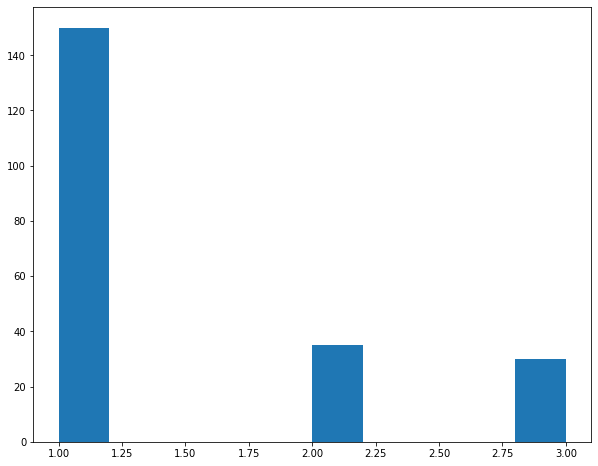

In [13]:
plt.figure(figsize=(10, 8))
plt.hist(data[5])
plt.show()

**2. (2 балла)** Примените ваш kNN-алгоритм для предсказания значения целевой переменной, используя кросс-валидацию на 3 фолдах. (Вам нужно изготовить из датафрейма массивы numpy `x` и `y`, которые можно скормить функциям, написанным в задачах 1 и 2. Чтобы получить массив из датафрейма можно использовать свойство `.values`.) Перебирая значения параметра $k$ — количества ближайших соседей — от 0 до 20 нарисуйте два графика зависимости качества предсказания (будем использовать accuracy) от $k$ — один для обучающей и один для тестовой выборок. Можно рисовать отдельную линию на графике для каждого фолда, либо рисовать их среднее±разброс. Значение p в метрике Минковского выберете на свой вкус.

In [14]:
x = data.values[:, :5]
y = data.values[:, 5]

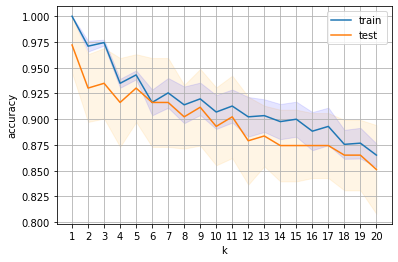

In [15]:
meantrs = []
trstd = []
meantes = []
testd = []
for k in range(1, 21):
    trls = []
    tels = []
    for xtr, ytr, xte, yte in strat_kfold_gen(x, y, 5, shuffle=True, seed=42):
        trls.append((knn_classifier_sklearn(xtr, ytr, xtr, k=k, weight=False, distance=1) == ytr).mean())
        tels.append((knn_classifier_sklearn(xtr, ytr, xte, k=k, weight=False, distance=1) == yte).mean())
    meantrs.append(sum(trls) / 5)
    trstd.append(np.array(trls).std())
    meantes.append(sum(tels) / 5)
    testd.append(np.array(tels).std())
import matplotlib.pyplot as plt
plt.fill_between(range(1, 21), np.array(meantes) - np.array(testd), np.array(meantes) + np.array(testd), alpha=0.1, color='orange')
plt.fill_between(range(1, 21), np.array(meantrs) - np.array(trstd), np.array(meantrs) + np.array(trstd), alpha=0.1, color='blue')

plt.plot(range(1, 21), meantrs, label='train')
plt.plot(range(1, 21), meantes, label='test')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.xticks(range(1, 21))
plt.legend()
plt.grid()

In [ ]:
trstdmeantes[3]

0.9721570161711007

Как зависит качество от значения $k$ для каждой выборки? Как выбрать оптимальное значение? 

*Ваш ответ:* Самое высокое качество при k = 1. 

**3. (0.5 балла)** Попробуйте улучшить качество модели, отмасштабировав данные таким образом, чтобы разброс значений всех переменных был примерно одинаковым (способ скейлинга на ваш выбор, см. модуль [sklearn-preprocessing](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)). 

In [16]:
xn = x - x.mean(axis=0)
xn = xn / xn.std(axis=0)
#xn = xn / np.sqrt((xn @ xn.T).diagonal())[:, None]

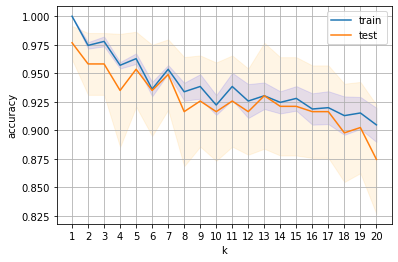

In [17]:
meantrs = []
trstd = []
meantes = []
testd = []
for k in range(1, 21):
    trls = []
    tels = []
    for xtr, ytr, xte, yte in strat_kfold_gen(xn, y, 5, shuffle=True, seed=42):
        trls.append((knn_classifier_sklearn(xtr, ytr, xtr, k=k, weight=False, distance=1) == ytr).mean())
        tels.append((knn_classifier_sklearn(xtr, ytr, xte, k=k, weight=False, distance=1) == yte).mean())
    meantrs.append(sum(trls) / 5)
    trstd.append(np.array(trls).std())
    meantes.append(sum(tels) / 5)
    testd.append(np.array(tels).std())
import matplotlib.pyplot as plt
plt.fill_between(range(1, 21), np.array(meantes) - np.array(testd), np.array(meantes) + np.array(testd), alpha=0.1, color='orange')
plt.fill_between(range(1, 21), np.array(meantrs) - np.array(trstd), np.array(meantrs) + np.array(trstd), alpha=0.1, color='blue')

plt.plot(range(1, 21), meantrs, label='train')
plt.plot(range(1, 21), meantes, label='test')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.xticks(range(1, 21))
plt.legend()
plt.grid()

In [18]:
meantes[0]

0.9767441860465116

Какие изменения в качестве произошли?

*Ваш ответ:* Качество чуть лучше, но все еще при k=1 лучше всего

## Задание 3.2 (3 балла)
Теперь рассмотрим другой [датасет](https://archive.ics.uci.edu/ml/datasets/Wine), являющийся результатом химического анализа вина. 

**1. (0.5 балла)** Загрузите датасет, выведите его размерности и распределение классов. Отмасштабируйте данные как и в предыдущем пункте.

In [19]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data

--2021-03-15 19:58:04--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10782 (11K) [application/x-httpd-php]
Saving to: ‘wine.data’

wine.data           100%[===================>]  10.53K  --.-KB/s    in 0s      

2021-03-15 19:58:05 (103 MB/s) - ‘wine.data’ saved [10782/10782]



In [20]:
data = pd.read_csv("./wine.data", header=None)

In [21]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


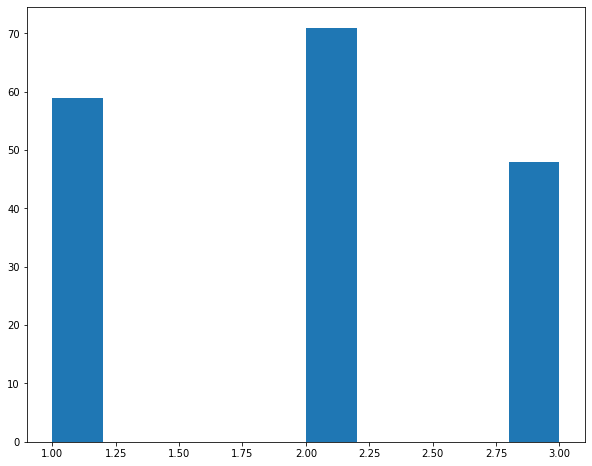

In [22]:
plt.figure(figsize=(10, 8))
plt.hist(data[0])
plt.show()

Наша итоговая цель в этом задании — нарисовать объекты датасета на плоскости и посмотреть, как алгоритм делит плоскость на классы и как это влияет на результаты на тестовой выборке. Кроме этого мы рассмотрим разные параметры алгоритма. Первая проблема состоит в том, что в датасете больше двух признаков — непонятно, как объекты изображать на плоскости. Обычно в такой ситуации используются методы снижения размерности (например, PCA), но мы про них ещё не говорили, поэтому воспользуемся другим подходом: попробуем выделить среди признаков те, которые (по одиночке) дают максимум информации о значении целевой переменной (это называется univariate feature selection).

**2. (0.5 балла)**  Функция `sklearn.feature_selection.mutual_info_classif` находит *взаимную информацию* между целевой переменной и каждым из признаков. Чем больше взаимная информация, тем больше знание одной переменной сообщает нам о возможных значениях другой переменной. С помощью этой функции выберите два признака, которые имеют максимальную взаимную информацию с целевой переменной. Создайте из них numpy-массив $X$ и создайте массив $y$ со значениями целевой переменной. После чего разделите данные на обучающую и тестовую выборки в соотношении 2:1, воспользовавшись вашей функцией `strat_kfold_gen` и взяв только один элемент из возвращённого списка (или генератора).

In [23]:
from sklearn.feature_selection import mutual_info_classif

In [24]:
mutual_info_classif(data.values[:, 1:], data.values[:, 0])

array([0.4603019 , 0.27669932, 0.08198207, 0.26109641, 0.19379439,
       0.41880022, 0.66781372, 0.12773036, 0.27509295, 0.55125713,
       0.46149874, 0.50651308, 0.55752174])

In [25]:
def getc(col):
    mcol = np.array(['r'] * col.shape[0])
    mcol[col == 0] = 'r'
    mcol[col == 1] = 'g'
    mcol[col == 2] = 'b'
    return mcol

In [26]:
datax = data.values[:, [6, -1]]
xn = datax - datax.mean(axis=0)
xn = xn / xn.std(axis=0)


In [27]:
xs, ys = np.meshgrid(np.linspace(min(xn[:, 0]), max(xn[:, 0]), num=100), np.linspace(min(xn[:, 1]), max(xn[:, 1]), num=100))

In [28]:
zs = knn_classifier_sklearn(xn, data.values[:, 0], np.concatenate((xs.reshape(-1, 1), ys.reshape(-1, 1)), axis=1), k=10)

In [29]:
Z = zs.reshape(100, 100)

In [30]:
Z

array([[3., 3., 3., ..., 2., 2., 2.],
       [3., 3., 3., ..., 2., 2., 2.],
       [3., 3., 3., ..., 2., 2., 2.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

Text(0.5, 1.0, 'K = 10')

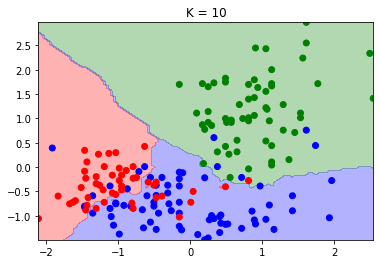

In [31]:
zs = knn_classifier_sklearn(xn, data.values[:, 0], np.concatenate((xs.reshape(-1, 1), ys.reshape(-1, 1)), axis=1), k=10, weight=False)
Z = zs.reshape(100, 100)
plt.contourf(xs, ys, Z, levels=[0.5, 1.5, 2.5, 3.5], alpha=0.3, colors=['g', 'b', 'r'])
plt.scatter(xn[:, 0], xn[:, 1], color=getc(data.values[:, 0]))
plt.title('K = 10')

Text(0.5, 1.0, 'K = 1')

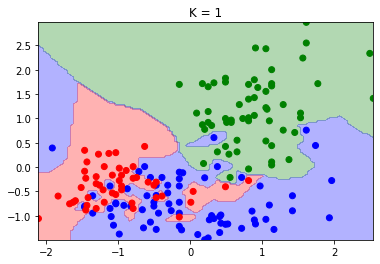

In [32]:
zs = knn_classifier_sklearn(xn, data.values[:, 0], np.concatenate((xs.reshape(-1, 1), ys.reshape(-1, 1)), axis=1), k=1, weight=False)
Z = zs.reshape(100, 100)
plt.contourf(xs, ys, Z, levels=[0.5, 1.5, 2.5, 3.5], alpha=0.3, colors=['g', 'b', 'r'])
plt.scatter(xn[:, 0], xn[:, 1], color=getc(data.values[:, 0]))
plt.title('K = 1')

В следующем задании вопользуйтесь примерами из интернета ([[1]](https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html), [[2]](https://stackoverflow.com/questions/45075638/graph-k-nn-decision-boundaries-in-matplotlib), [[3]](https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/auto_examples/tutorial/plot_knn_iris.html) и т.д. на ваш выбор), чтобы построить график следующего типа. Каждая точка плоскости (decision boundaries) покрашена в свой цвет в зависимости от того, какое предсказание сделает алгоритм для этой точки, а объекты раскрашены в тот цвет, какой у них истинный $y$.

![example.png](example.png)

**3. (2 балла)** Переберите $M$ значений параметра $k$ (можете добавить значение 0 как индикатор использования взвешенного kNN), $L$ значений параметра $p$ (порядок расстояния Минковского) и постройте сетку $L \times M$  графиков типа выше. ($M$ и $L$ — небольшие целые числа, больше 3.)

На графиках должны быть:

- подпись: набор параметров и качество (accuracy) до третьего знака после запятой;
- окрашенные в цвет истинного класса точки обучающей и тестовой выборки
    - сделайте маркеры обучающей и тестовой выборок различными (например, треугольники и кружочки/черная и белая обводка/маленький и большой размер);
- границы принятия решений (decision boundaries) на основе обученного (на обучающей выборке) алгоритма kNN;
- общее название сетки графиков, где в том числе указаны номера признаков, выбранные в предыдущем пункте.

In [33]:
xn = data.values[:, 1:] - data.values[:, 1:].mean(axis=0)
xn /= xn.std(axis=0)
y = data.values[:, 0]

In [34]:
plt.rcParams["figure.figsize"] = (20, 20)

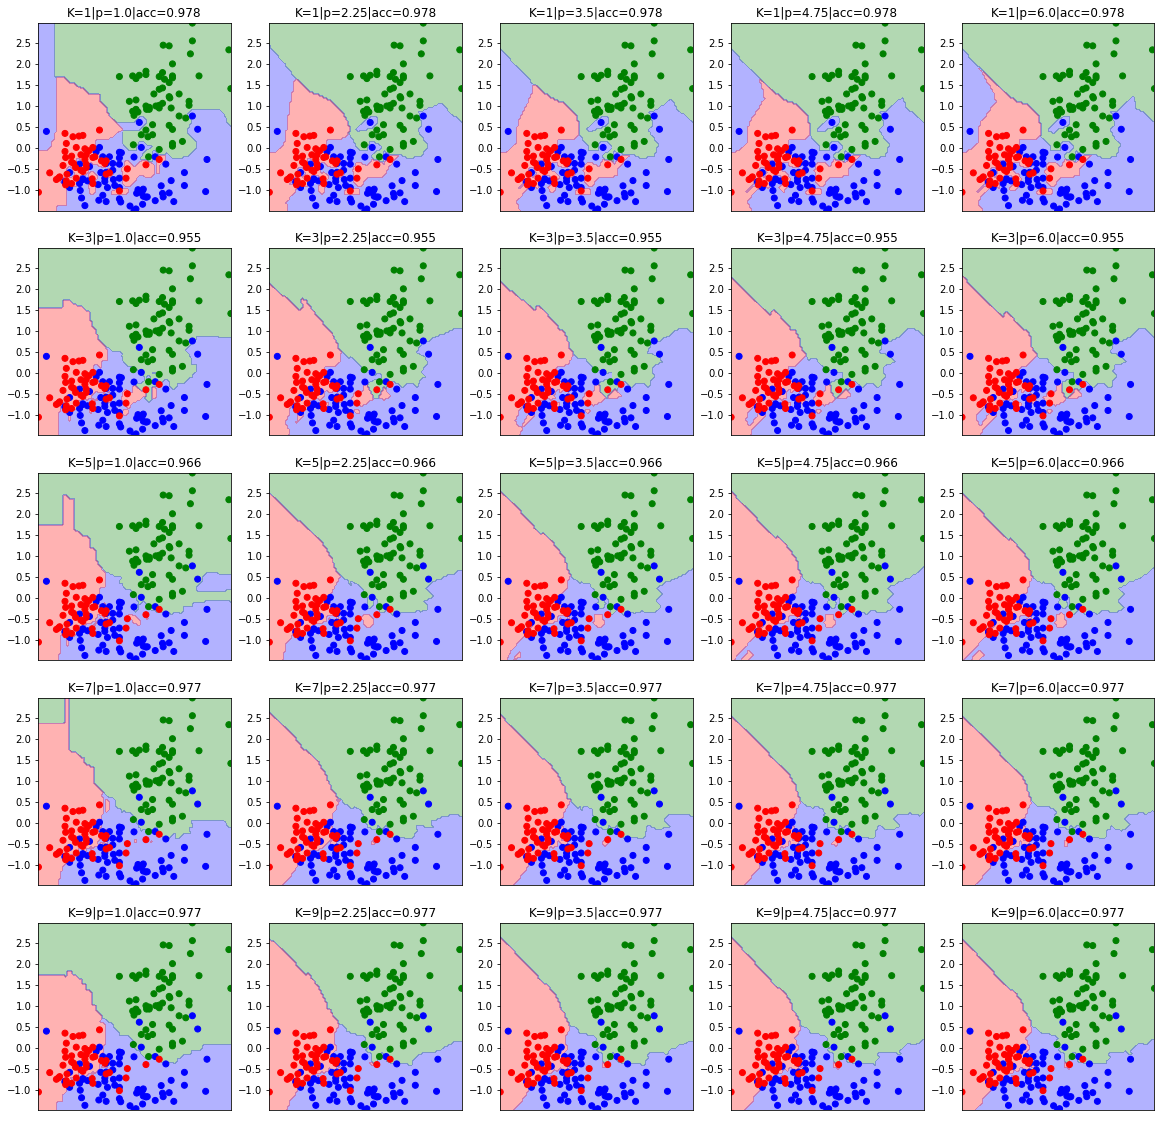

In [35]:
cou = 0
for k in (range(1, 11, 2)):
    for p in np.linspace(1, 6, 5):
        cou += 1
        trls = []
        tels = []
        for xtr, ytr, xte, yte in strat_kfold_gen(xn, y, 5, shuffle=True, seed=42):
            trls.append((knn_classifier_sklearn(xtr, ytr, xtr, k=k, weight=False, distance=1) == ytr).mean())
            tels.append((knn_classifier_sklearn(xtr, ytr, xte, k=k, weight=False, distance=1) == yte).mean())
        datax = data.values[:, [6, -1]]
        xn2 = datax - datax.mean(axis=0)
        xn2 = xn2 / xn2.std(axis=0)
        xs, ys = np.meshgrid(np.linspace(min(xn2[:, 0]), max(xn2[:, 0]), num=100), np.linspace(min(xn2[:, 1]), max(xn2[:, 1]), num=100))
        zs = knn_classifier_sklearn(xn2, data.values[:, 0], np.concatenate((xs.reshape(-1, 1), ys.reshape(-1, 1)), axis=1), k=k, distance=p, weight=False)
        Z = zs.reshape(100, 100)
        ax = plt.subplot(5, 5, cou, label='K={k}|p={p}|acc={sum(tels) / len(tels)}')
        ax.contourf(xs, ys, Z, levels=[0.5, 1.5, 2.5, 3.5], alpha=0.3, colors=['g', 'b', 'r'])
        ax.scatter(xn2[:, 0], xn2[:, 1], color=getc(data.values[:, 0]))
        ax.set(title=f'K={k}|p={p}|acc={round(sum(tels) / len(tels), 3)}')
        ax.set(xticks=[])

У какого набора параметров получилось лучшее качество?

Объясните как параметры влияют на decision boundaries.

*Ваш ответ: При переходе к большему K разделение все более становится похожим на линейное, меньше резких изгибов и исчезают островки разных цветов.*